# Section 1: Linear Regression


In this notebook, we will discuss Linear Regression, one of the Linear models in ML. Linear Regression is also known as MLE estimate and Ordinary Least Squares (OLS) method. Also, we will look at variants of Linear Regression, i.e Lasso and Ridge Regression.

### Formulation

We start by formulating the problem of line fitting in 2D space. One should note that the problem of line fitting can very well be extended to data in d-dimensions. 
A vectorized equation for line fitting is as follows:

\begin{equation}
\mathbf{y} = \mathbf{w}^{\top}\mathbf{x}
\end{equation}

Here, vector $\mathbf{x}$ is a single data point which need not lie on the line. This could lead to errors in predicting $\mathbf{y}$. We would like to account this error for the whole dataset $\mathbf{X}$. Hence, the error or loss equation is as follows:

\begin{equation}
\mathbf{E} = \mathbf{Y - Xw}
\end{equation}

To obtain optimal values of $\mathbf{w}$, we would like to minimize the MSE loss.

\begin{equation}
\min_{\mathbf{w}} \mathbf{J(w)} = \mathbf{\frac{1}{N} {E}^{\top}E}
\end{equation}

Equation when expanded is,

\begin{equation}
\min_{\mathbf{w}} \mathbf{J(w)} = \mathbf{\frac{1}{N} (Y^{\top}Y + w^{\top}X^{\top}Xw - 2 \cdot w^{\top}(X^{\top}Y))}
\end{equation}

<br/>
where $\mathbf{Y} \in \mathbf{R^{N \times 1}}$, $\mathbf{X} \in \mathbf{R^{N \times d}}$, and $\mathbf{w} \in \mathbf{R^{d \times 1}}$.

#### Analytic or Closed Form solution

We can get the "best" $\mathbf{w}$ by differentiating our loss function with respect to w and equate to zero. This minimizes our MSE loss.

\begin{equation}
\mathbf{w} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{Y}
\end{equation}

Note that this is a one step solution towards obtaining optimal $\mathbf{w}$.

### Implementation of Linear Regression

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set();

#### Generating and visualizing data set

In [2]:
# Generating a regression dataset
num_samples=400
X, Y = make_regression(n_samples=num_samples, n_features=2, noise=5)

# Absorbing column of bias in X
bias_ones = np.ones((num_samples, 1))
X = np.hstack((X, bias_ones))

Self Excercise: In the above code for generating regression dataset, change the noise level to a different integer and check the final error rate below. Is there a correlation between the noise and the final error? Why?

In [3]:
# Train-test split of input data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print("X_train: num_samples {}, num_features {}" .format((X_train.shape)[0], (X_train.shape)[1]))
print("X_test: num_samples {}, num_features {}" .format((X_test.shape)[0], (X_test.shape)[1]))

X_train: num_samples 320, num_features 3
X_test: num_samples 80, num_features 3


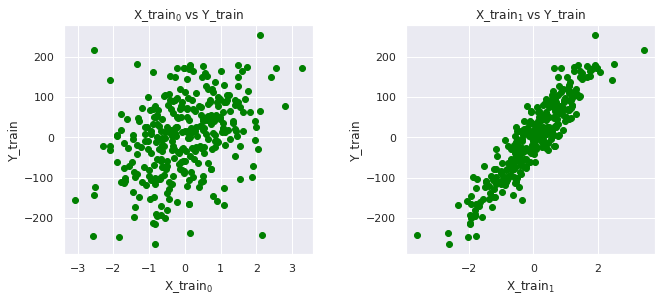

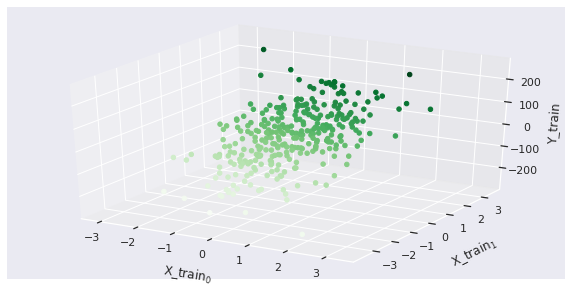

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].scatter(X_train[:, 0], Y_train, label='Point', color='green')
axs[0].set_title('X_train$_{0}$ vs Y_train')
axs[0].set_xlabel("X_train$_{0}$")
axs[0].set_ylabel("Y_train")

axs[1].scatter(X_train[:, 1], Y_train, label='Point', color='green')
axs[1].set_title('X_train$_{1}$ vs Y_train')
axs[1].set_xlabel("X_train$_{1}$")
axs[1].set_ylabel("Y_train")
plt.tight_layout(pad=3)

fig3d = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:, 0], X_train[:, 1], Y_train, c=Y_train, cmap='Greens', depthshade=False);
ax.set_xlabel("X_train$_{0}$", labelpad=15)
ax.set_ylabel("X_train$_{1}$", labelpad=15)
ax.set_zlabel("Y_train", labelpad=5);

#### Code for linear regression

In [5]:
# Getting optimal values of w using closed-form solution for OLS
def calc_analytic_linear_reg(X_train, Y_train):
    w = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ Y_train
    return w

In [6]:
trained_weights = calc_analytic_linear_reg(X_train, Y_train)

#### Plotting the output

Error:  4.473147354450324


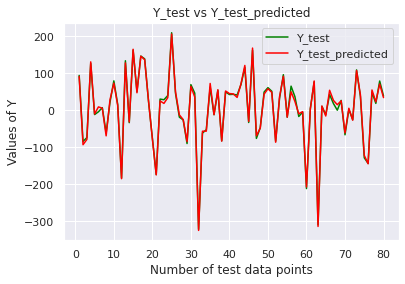

In [7]:
# Plotting predicted values of Y with true values of Y 
# using trained weights on test set.

sns.set();

Y_test_predicted = X_test @ trained_weights
plt.plot(range(1,(Y_test.shape)[0]+1), Y_test, color='green', label='Y_test')
plt.plot(range(1,(Y_test.shape)[0]+1), Y_test_predicted, color='red', label='Y_test_predicted')
plt.legend()
plt.title('Y_test vs Y_test_predicted')
plt.xlabel('Number of test data points')
plt.ylabel('Values of Y');
print("Error: ", np.mean(abs(Y_test - Y_test_predicted)))

From the above graph, we can see that the values of Y_test and Y_test_predicted are pretty close. Since the linear regression is a simple optimization problem, we are lucky to have a single-step analytic solution. However, this might not always be the case with more complex, non-linear models such as neural networks.

In addition, one must note that numpy's inverse function performs pseudo-inverse of a matrix instead of regular inverse.

# Section 2: Ridge Regression & Lasso Regression

In this section we will explore regularization of linear regression, in particular __ridge__ and __lasso__ regression. These methods seeks to alleviate the consequences of poorly conditioned equations, multi-collinearity, and overfitting.

- When variables are _highly correlated_ a large coefficient in one variable may be alleviated by a large coefficient in another variable, which is negatively correlated
- _Regularization_ imposes an upper threshold on the values taken by the coefficients, thereby producing a more parsimonious solution, and a set of coefficients with smaller variance

## Ridge regression

#### Ridge regression as a L2 constrained optimization problem

Ridge regression is motivated by a __constrained minimization__ problem, which can be formulated as follows:
$$
\begin{align}
{\bf w}_{ridge} = {\arg\min}_{\mathbf{w} \in \mathbb{R}^n} \sum_{i=1}^m (y_i - \mathbf{x}_i^T \mathbf{w})^2 \\
\mathrm{subject\ to} \sum_{j=1}^{n} \mathbf{w}_j^2 \leq t
\end{align}
$$
For $t \geq 0$. The feasible set for this minimization problem is therefore constrained to be $S(t) := \{\mathbf{w} \in \mathbb{R}^n, ||\mathbf{w}||_2^2 \leq t\}$. Using a __Lagrange multiplier__ we can rewrite the problem as a $L_2$ penalty in OLS problem as,
$$
{\bf w}_{ridge} = {\arg\min}_{\mathbf{w} \in \mathbb{R}^n} \sum_{i=1}^m (y_i - \mathbf{x}_i^T \mathbf{w})^2 + \lambda \sum_{j=1}^{n} \mathbf{w}_j^2
$$
Where $\lambda \geq 0$ and where there is a one-to-one correspondence between $t$ and $\lambda$.

#### Ridge regression as MAP estimate

Previously, we looked at an analytic solution for our MLE estimate (or OLS) is as follows:

\begin{equation}
\mathbf{w} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{Y}
\end{equation}

In lecture, we discussed that a model might face errors from bias and variance. As a way to generalize well and reduce errors, we would like to use Ridge regression, aka $\mathrm{L_2}$ regularization and MAP estimation. We will see why MAP estimate is a better solution than MLE for our linear regression model.

Although MLE works well for linear regression, one must note that MLE is an unconstrained point-based estimation of parameter $\mathbf{w}$. This means that the learnt $\mathbf{w}$ will try to fit every point from the training point, especially outliers or noise, leading to overfitting.

Due to the unconstrained point-based approach MLE follows, the ability of parameter $\mathbf{w}$ to *explain* the data fails in scenarios where we have outliers, less data, or when parameter modeling itself is wrong.

MAP modifies the MLE objective. Intuitively, MAP puts constraints on the parameter modeling. This constraint is nothing but the priors in our Bayes' theorem equation.

\begin{equation}
P(\mathbf{w} | \mathbf{X}) = \frac{P(\mathbf{X} | \mathbf{w}) \times P(\mathbf{w})}{P(\mathbf{X})}
\end{equation}

where,

  *   $P(\mathbf{w} | \mathbf{X})$ - Posterior distribution
  *   $P(\mathbf{X} | \mathbf{w})$ - Conditional distribution (or, Likelihood, from a Frequentist interpretation)
  *   $P(\mathbf{w})$ -  Prior distribution (or, a priori)
  *   $P(\mathbf{X})$ - Probability distribution of $\mathbf{X}$

Note that MAP isn't completely Bayesian and is considered a constrained point-based estimate. MAP tries to model the parameters by dragging our estimation towards the priors' belief. However, one must remember that as number of datapoint increases, the information contained in the data and in the prior will shift towards the data and the effect of priors will be gone. Hence, the posterior will center around the data-only estimate of the MLE. (See [Bernstein–von Mises theorem](https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem) for more information).

Let's use the Bayes' theorem and principle of MAP to derive a solution for linear regression.

We assume that our prior about $\mathbf{w}$ is Gaussian. This doesn not mean that the elements of weight vector $\mathbf{w}$ is actually sampled from a Gaussian. What it means is that our assumption about $\mathbf{w}$ being Gaussian is a belief we have placed before we have any evidence of $\mathbf{w}$ actual distribution. Therefore,

\begin{equation}
P(\mathbf{w}) = \frac{1}{\sqrt{2 \pi \tau^{2}}} e^\frac{-\mathbf{w}^{\top}\mathbf{w}}{2\tau^{2}}
\end{equation}

Our posterior distribution is as follows:

\begin{equation}
\mathbf{w} = P(\mathbf{w}|y_1,\mathbf{x}_1,...,y_n,\mathbf{x}_n)\\
\end{equation}

Since $P(X)$ or $P(x_{1},......., x_{n})$ is a constant, our MAP solution looks as follows:

\begin{align}
J(\mathbf{w}) &= \operatorname*{argmax}_{\mathbf{\mathbf{w}}} P(\mathbf{w}|y_1,\mathbf{x}_1,...,y_n,\mathbf{x}_n)\\
              &= \operatorname*{argmax}_{\mathbf{\mathbf{w}}} \frac{P(y_1,\mathbf{x}_1,...,y_n,\mathbf{x}_n|\mathbf{w})P(\mathbf{w})}{P(y_1,\mathbf{x}_1,...,y_n,\mathbf{x}_n)}\\
              &= \operatorname*{argmax}_{\mathbf{\mathbf{w}}} P(y_1,\mathbf{x}_1,...,y_n,\mathbf{x}_n|\mathbf{w})P(\mathbf{w})\\
\end{align}

When simplified,

\begin{align}
J(\mathbf{w}) &= \operatorname*{argmin}_{\mathbf{w}} \frac{1}{\mathbf{N}} \sum_{i=1}^\mathbf{N} (y_i - \mathbf{x}_i^\top\mathbf{w})^2 + \lambda || \mathbf{w}||_2^2 \\
\lambda &= \frac{\sigma^2}{n\tau^2}
\end{align}

#### Solution for Ridge Regression

We can write the vectorized form of our objective function above as:
\begin{equation}
J(\mathbf{W}) = \frac{1}{2 \mathbf{N}} (XW - \mathbf{y})^T (XW - \mathbf{y}) + \frac{\lambda}{2 \mathbf{N}} W^T W 
\end{equation}
and its gradient as:
\begin{equation}
\frac{\partial J(W)}{\partial W} = \frac{1}{\mathbf{N}} X^T(XW - \mathbf{y}) + \frac{\lambda}{\mathbf{N}} W
\end{equation}

- Gradient descent solution for Ridge regression is:
\begin{equation}
W^{(t+1)} := W^{(t)} - \alpha \frac{\partial J(W^{(t)})}{\partial W} 
\end{equation}

- Closed form or analytic solution for Ridge regression is:

\begin{equation}
\mathbf{w} = (\mathbf{X^\top} \mathbf{X} + \mathbf\lambda \mathbf{I})^{-1}\mathbf{X}^\top \mathbf{Y}
\end{equation}



### Implementation of Ridge Regression

#### Imports

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()

#### Generating and visualization of the data set

We will now look at applying ridge regression to a noisy non-linear data. To this end, we will use a simulated dataset which consists of a sine wave with uniform noise added.

For simplicity and interest:
- We center the data (such that a y-intercept parameter is not needed) : $y:=y−mean(y)$
- Add a second explanatory variable which is the first variable ($x$) squared 
- Normalize the explanatory data so that the unit length of each feature is 1
- The design matrix is therefore given by: $X = [x, x^2]$ normalized

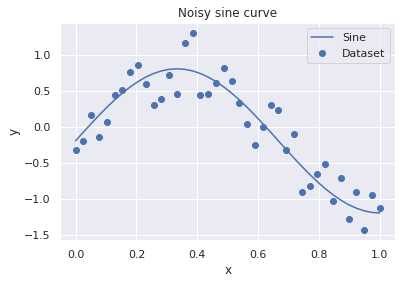

In [9]:
#Generating sine curve and uniform noise
x = np.linspace(0, 1, 40)
noise = 1*np.random.uniform(  size = 40)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = (y + noise).reshape(-1,1)

#Centering the y data
y_noise = y_noise - y_noise.mean()

#Design matrix is x, x^2
X = np.vstack((2*x, x**2)).T

#Normalizing the design matrix to facilitate visualization
X = X / np.linalg.norm(X,axis = 0)

#Plotting the result
plt.scatter(x,y_noise, label = 'Dataset')
plt.plot(x,y - y.mean(),label = 'Sine')
plt.title('Noisy sine curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


#### Code for ridge regression

In [10]:
def costfunction(X, y, W):
    '''Cost function for linear regression'''
    #Initialization of useful values 
    m = np.size(y)
    
    #Vectorized implementation
    h = X @ W
    J = float((1./(2*m)) * (h - y).T @ (h - y));    
    return J


def costFunctionRidge(X, y, W, lamda = 10):
    '''Cost function for ridge regression (regularized L2)'''
    #Initialization
    m = len(y) 
    J = 0
    
    #Vectorized implementation
    h = X @ W
    J_reg = (lamda / (2*m)) * np.sum(np.square(W))
    J = float((1./(2*m)) * (h - y).T @ (h - y)) + J_reg;
    return J


def gradient_descent(X, y, W, alpha = 0.0005, num_iters=1000):
    '''Gradient descent for linear regression'''
    #Initialisation of useful values 
    m = np.size(y)
    J_history = np.zeros(num_iters)
    W_0_hist, W_1_hist = [], [] #For plotting afterwards
    
    for i in range(num_iters):
        #Cost and intermediate values for each iteration
        J_history[i] = costfunction(X, y, W)
        W_0_hist.append(W[0,0])
        W_1_hist.append(W[1,0])
        
        #Grad function in vectorized form
        h = X @ W
        gradient = (1/m)*(X.T @ (h-y))
        W = W - alpha * gradient       
    return W, J_history, W_0_hist, W_1_hist


def gradient_descent_ridge(X, y, W, alpha = 0.0005, lamda = 10,num_iters=1000):
    '''Gradient descent for ridge regression'''
    #Initialisation of useful values 
    m = np.size(y)
    J_history = np.zeros(num_iters)
    W_0_hist, W_1_hist = [], [] #Used for three D plot

    for i in range(num_iters):
        #Hypothesis function
        h = np.dot(X,W)
        
        #Grad function in vectorized form
        W = W - alpha * (1/m)* (  (X.T @ (h-y)) + lamda * W )
           
        #Cost function in vectorized form       
        J_history[i] = costFunctionRidge(X, y, W, lamda)
           
        #Calculate the cost for each iteration(used to plot convergence)
        W_0_hist.append(W[0,0])
        W_1_hist.append(W[1,0])   
    return W ,J_history, W_0_hist, W_1_hist


def ridge_regression_closed_form(X_mat, Y_vec, lamda=10):
    '''Closed-form solution of Ridge regression'''
    m, n = X_mat.shape
    I = np.eye((n))
    w =  np.linalg.inv(X_mat.T @ X_mat + lamda * I) @ X_mat.T @ Y_vec
    return w


#### Plotting cost function without regularization

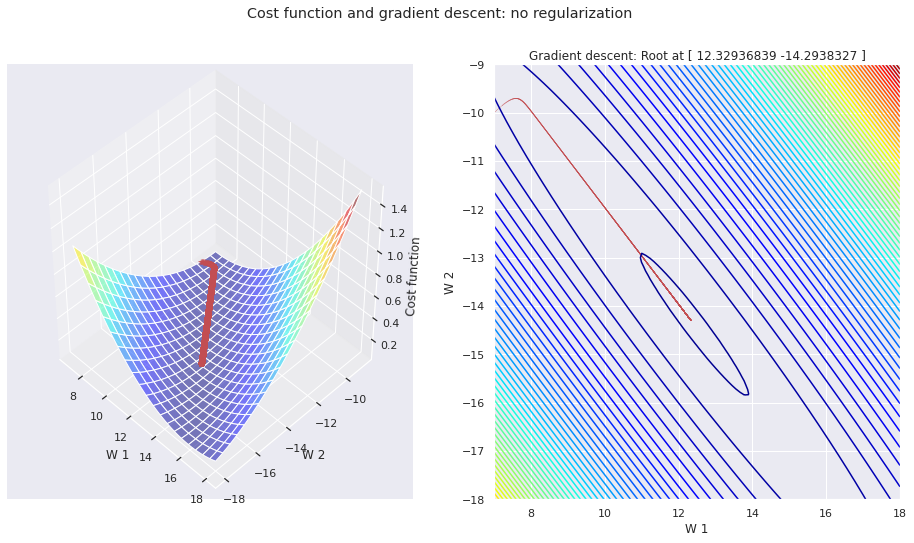

In [11]:
#Setup of meshgrid of W values
T0, T1 = np.meshgrid(np.linspace(7,18,100),np.linspace(-18,-9,100))

#Computing the cost function for each W combination
zs = np.array(  [costfunction(X, y_noise.reshape(-1,1),np.array([t0,t1]).reshape(-1,1)) 
                     for t0, t1 in zip(np.ravel(T0), np.ravel(T1)) ] )
#Reshaping the cost values    
Z = zs.reshape(T0.shape)


#Computing the gradient descent
W_result, J_history, W_0, W_1 = gradient_descent(X, y_noise, np.array([7,-10]).reshape(-1,1), alpha = 1, num_iters=5000)

#Angles needed for quiver plot
anglesx = np.array(W_0)[1:] - np.array(W_0)[:-1]
anglesy = np.array(W_1)[1:] - np.array(W_1)[:-1]

fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(T0, T1, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(W_0, W_1, J_history, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')

ax.set_xlabel('W 1')
ax.set_ylabel('W 2')
ax.set_zlabel('Cost function')
ax.view_init(45, -45)

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T0, T1, Z, 70, cmap = 'jet')
ax.quiver(W_0[:-1], W_1[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)
ax.set_xlabel('W 1')
ax.set_ylabel('W 2')
ax.set_title('Gradient descent: Root at {}'.format(W_result.ravel()))

plt.suptitle('Cost function and gradient descent: no regularization')
plt.show()

#### Plotting the cost function with large regularization (ridge regression)

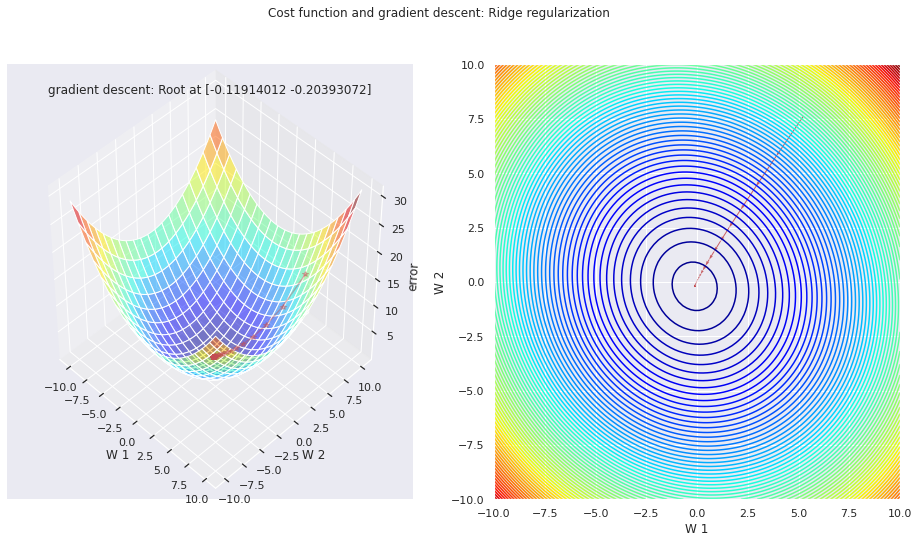

In [12]:
# lamda
l = 10

#Setup of meshgrid of W values
T1, T2 = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))

#Computing the cost function for each W combination
zs = np.array(  [costFunctionRidge(X, y_noise.reshape(-1,1), np.array([t1,t2]).reshape(-1,1),l) 
                     for t1, t2 in zip(np.ravel(T1), np.ravel(T2)) ] )
#Reshaping the cost values    
Z = zs.reshape(T1.shape)


#Computing the gradient descent
W_result_reg, J_history_reg, W_0, W_1 = gradient_descent_ridge(X, y_noise, np.array([7.,10.]).reshape(-1,1), 0.8, l, num_iters=5000)


#Angles needed for quiver plot
anglesx = np.array(W_0)[1:] - np.array(W_0)[:-1]
anglesy = np.array(W_1)[1:] - np.array(W_1)[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(T1, T2, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(W_0, W_1, J_history_reg, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')

ax.set_xlabel('W 1')
ax.set_ylabel('W 2')
ax.set_zlabel('error')
ax.set_title('gradient descent: Root at {}'.format(W_result_reg.ravel()))
ax.view_init(45, -45)


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T1, T2, Z, 100, cmap = 'jet')
ax.quiver(W_0[:-1], W_1[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)
ax.set_xlabel('W 1')
ax.set_ylabel('W 2')

plt.suptitle('Cost function and gradient descent: Ridge regularization')
plt.show()

## Lasso Regression

#### Lasso regression as a L1 constrained optimization problem

In the previous section, we saw Ridge Regression as a constrained minimization technique where the objective function had a $\mathrm{L_2}$ norm of the weights. Lasso Regression, aka $\mathrm{L_1}$ regularization, is another constrained minimization technique where the objective consists of $\mathrm{L_1}$ norm of the weights.

\begin{equation}
\mathbf{J(w)} = \frac{1}{\mathbf{N}} \sum_\mathbf{i=1}^\mathbf{N} (\mathbf{y_{i} - w^{\top}x)^{2} + \lambda|| \mathbf{w}||_1}
\end{equation}

#### Lasso as MAP estimate
In the previous section we saw that assuming a Gaussian prior on $\mathbf{w}$, i.e. $P(\mathbf{w}) = \frac{1}{\sqrt{2 \pi \tau^{2}}} e^\frac{-\mathbf{w}^{\top}\mathbf{w}}{2\tau^{2}}$. If we were to assume a Laplace prior instead (Check [Laplace Distribution](https://en.wikipedia.org/wiki/Laplace_distribution)), we will get a Lasso objective.
\begin{equation}
P(\mathbf{w}) = \frac{1}{2 \sqrt{\tau^{2}}} e^\frac{-\lambda ||\mathbf{w}||_1}{\tau^{2}}
\end{equation}

#### Solution for Lasso

##### Coordinate Descent (Optional Read)
We will be using [coordinate descent algorithm](https://en.wikipedia.org/wiki/Coordinate_descent) to solve the Lasso objective. Coordinate descent successively minimizes along coordinate directions to find the minimum of a function. At each iteration, the algorithm determines a coordinate, then minimizes over the corresponding hyperplane while fixing all other coordinates. It is based on the idea that minimization can be achieved by minimizing along one direction at a time, i.e. by solving a much simpler univariate problem in a loop. In the simple case of cyclic coordinate descent, we cycle through all features one at a time, minimizing the cost function with respect to each coordinate.

- Start with $\mathbf{x}^{0} = (x_1^0, \dots, x_n^0)$
- Round $k+1$ defines $\mathbf{x}^{(k+1)}$ from $\mathbf{x}^{(k)}$ by iteratively solving the single variable optimization problem
     - $\mathbf{x}_i^{(k+1)} = {\arg\min}_{w} f(x_1^{(k+1)}, \dots, x_{i-1}^{(k+1)}, w, x_{i+1}^{(k)}, \dots, x_n^{(k)})$
     - i.e. $x_i := x_i - \alpha \frac{\partial f}{\partial x_i}(\mathbf{x})$
     - Repeat for each variable $x_i$ in $\mathbf{x}$ for $i = 1, \dots, n$.
     
If a closed form solution to the single variable optimization exists then we can update the parameter directly at each step:
- $w_j$ = closed form solution

For Lasso, the closed form solution is written as:
\begin{equation}
    \begin{cases}
        w_j = \rho_j + \lambda \quad\quad \mathrm{for} \quad \rho_j < -\lambda \\
        w_j = 0 \quad\quad\quad \mathrm{for} \quad -\lambda \leq \rho_j \leq \lambda \\
        w_j = \rho_j - \lambda \quad\quad \mathrm{for} \quad \rho_j > \lambda
    \end{cases}
\end{equation}

Note that the term $\rho_j$ can be rewritten to simplify the implementation
\begin{equation}
\rho_j = \sum_{i=1}^{m}x_j^{(i)} \left( y^{(i)} - \sum_{k \neq j}^{n} w_k x_k^{(i)} \right) = \sum_{i=1}^{m} x_j^{(i)} \left( y^{(i)} - \hat{y}_{pred}^{(i)} + w_j x_j^{(i)} \right)
\end{equation}

##### Update Rule for Lasso
Repeat until convergence or max number of iterations:
- For $j = 0, \dots, n$
- Compute $\rho_j = \sum_{i=1}^{m}x_j^{(i)} \left( y^{(i)} - \sum_{k \neq j}^{n} w_k x_k^{(i)} \right) = \sum_{i=1}^{m} x_j^{(i)} \left( y^{(i)} - \hat{y}_{pred}^{(i)} + w_j x_j^{(i)} \right)$
- Set $w_j = S(\rho_j, \lambda)$
- Note that if there is a constant term, then it is not regularized so $w_0 = \rho_0$

### Implementation of Lasso

#### Imports

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import datasets

%matplotlib inline
plt.style.use('seaborn-white')

#### Dataset

We will be using the well known __diabetes__ dataset taken from Sklearn's built in datasets

In [14]:
#Load the diabetes dataset. In this case we will not be using a constant intercept feature
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target.reshape(-1,1)

#### Code for Lasso

In [15]:
def soft_threshold(rho, lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0
    

def coordinate_descent_lasso(W, X, y, lamda = .01, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize w_0'''
    
    #Initialisation of useful values 
    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before
    
    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n):
            
            #Vectorized implementation
            X_j = X[:,j].reshape(-1,1)
            y_pred = X @ W
            rho = X_j.T @ (y - y_pred  + W[j]*X_j)
        
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    W[j] =  rho 
                else:
                    W[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                W[j] =  soft_threshold(rho, lamda)   
            
    return W.flatten()

#### Lasso coefficient paths

(0.06309573444801933, 1584.893192461114, -849.8147108555941, 820.6104516733533)

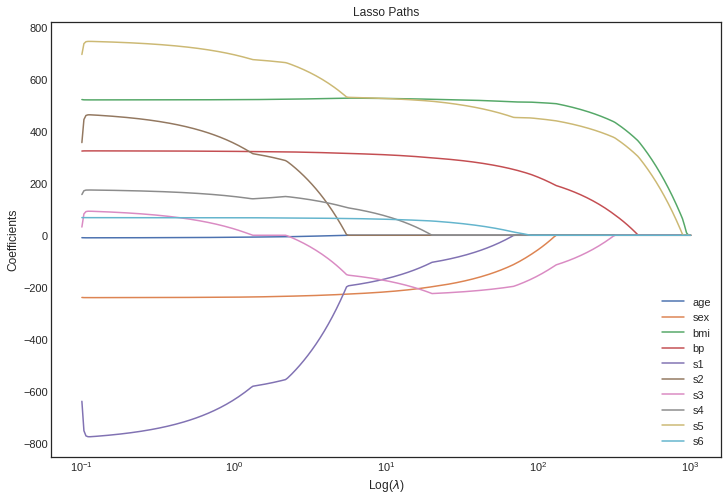

In [16]:
# Initialize variables
m,n = X.shape
initial_W = np.ones((n,1))
W_list = list()
lamda = np.logspace(0,4,300)/10 #Range of lambda values

#Run lasso regression for each lambda
for l in lamda:
    W = coordinate_descent_lasso(initial_W, X, y, lamda = l, num_iters=100)
    W_list.append(W)

#Stack into numpy array
W_lasso = np.stack(W_list).T

#Plot results
n,_ = W_lasso.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(lamda, W_lasso[i], label = diabetes.feature_names[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend()
plt.axis('tight')